In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

from scipy.stats import ttest_rel, ttest_1samp, pearsonr
from statsmodels.stats.multitest import multipletests

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.plotting import aligned_imshow_cbar

%matplotlib inline
mpl.rcParams['font.size'] = 13

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_derivatives = os.path.join(path_root, 'data/main_fmri_study/derivatives')
path_out = os.path.join(path_derivatives, 'ppi')
path_nistats = os.path.join(path_derivatives, 'nistats')
path_jags = os.path.join(path_derivatives, 'jags')
path_betamats = os.path.join(path_out, 'betamats')
path_parcellations = os.path.join(path_out, 'parcellations')
path_exclusion_csv = os.path.join(path_nistats, 'exclusion/exclusion.csv')
path_betamats_custom_roi = os.path.join(path_betamats, 'customROI')

# Behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape

# Behavioral modelling parameters
alpha_pdci_mle = np.load(os.path.join(
    path_jags, 
    'parameter_estimates/alpha_pdci_mle_3digits.npy'))
beta_pdci_mle = np.load(os.path.join(
    path_jags, 
    'parameter_estimates/beta_pdci_mle_3digits.npy'))

# PPI model regressors information
beta_names = ['physio', 'dec_ons', 'dec_wcor', 'res_lbp', 'res_rbp', 
              'ppi_out_ons', 'ppi_out_perr', 'out_ons', 'out_perr', 'out_off',
              'reg_intercept']
n_regressors = len(beta_names)

# ROI information
df_custom = pd.read_csv(
    os.path.join(path_parcellations, 'custom_roi/custom_roi_table.csv'),
    sep=' ')
n_rois = len(df_custom)
n_nets = len(df_custom['netName'].unique())

# Load exclusion table
df_exclusion = pd.read_csv(path_exclusion_csv, index_col=0)
ok_index = df_exclusion.index[df_exclusion['ok_all']]

### Load beta matrices 

- `beta_mats_agg`: beta_matrices (shape `n_regressors` $\times$ `n_rois` $\times$ `n_rois)` aggregated over subjects and tasks)
- `beta_mats_agg_sym`: version with beta weights symmetrized for connections `ij` and `ji` 

In [3]:
beta_idx = beta_names.index('ppi_out_perr')

beta_mats_agg = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
beta_mats_agg_sym = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
nets_mats_agg_sym = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_nets, n_nets))

for sub, sub_name in enumerate(meta['dim1']):
    for con, con_name in enumerate(meta['dim2']):
        
        beta_mats_fname = f'sub-{sub_name}_task-{con_name}_betamats.npy'
        beta_mats = np.load(os.path.join(path_betamats_custom_roi, 
                                         beta_mats_fname))
        
        beta_mats_agg[sub, con] = beta_mats
        beta_mats_agg_sym[sub, con] = beta_mats + np.transpose(beta_mats, 
                                                               (0, 2, 1))
        
for i, net_i in enumerate(df_custom['netName'].unique()):
    for j, net_j in enumerate(df_custom['netName'].unique()):
        net_i_idx = df_custom[df_custom['netName'] == net_i].index
        net_j_idx = df_custom[df_custom['netName'] == net_j].index
        nets_mats_agg_sym[:, :, :, i, j] = np.mean(
            beta_mats_agg_sym[:, :, :, net_i_idx, :][:, :, :, :, net_j_idx], 
            axis=(-1, -2))
        
# Filter excluded subjects
beta_mats_agg = beta_mats_agg[ok_index]
beta_mats_agg_sym = beta_mats_agg_sym[ok_index]
nets_mats_agg_sym = nets_mats_agg_sym[ok_index]
        
print('beta_mats_agg_sym.shape: ', beta_mats_agg_sym.shape)
print('nets_mats_agg_sym.shape: ', nets_mats_agg_sym.shape)

beta_mats_agg_sym.shape:  (29, 2, 11, 14, 14)
nets_mats_agg_sym.shape:  (29, 2, 11, 2, 2)


In [4]:
data = []
for sub, sub_name in enumerate(df_exclusion.loc[ok_index, 'sub']):
    for con, con_name in enumerate(meta['dim2']):
        for net, netidx in {'↑pe': (0, 0), '↓pe': (1, 1), 'mix': (0, 1)}.items():
            data.append(
                [
                    nets_mats_agg_sym[sub, con, beta_idx, netidx[0], netidx[1]],
                    sub_name,
                    con_name,
                    net
                ]
            )
            
df = pd.DataFrame(data, columns=['beta', 'sub_name', 'condition', 'net'])

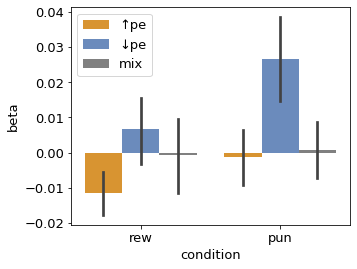

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))
bp = sns.barplot(
    x='condition', 
    y='beta', 
    hue='net',
    data=df,
    ax=ax,
    palette={'↑pe': '#f49915', '↓pe': '#5E88CA', 'mix': 'gray'}
)
plt.legend(loc='upper left')
plt.show()

### Comparison on the level of single connections
- Which connections significantly differ from 0 in reward condition?
- Which connections significantly differ from 0 in punishment condition?
- Which connections significantly differ between conditions?

In [6]:
beta_mat_neqzero_rew = np.zeros((3, n_rois, n_rois))
beta_mat_neqzero_pun = np.zeros((3, n_rois, n_rois))
beta_mat_rew_minus_pun = np.zeros((3, n_rois, n_rois))

triu_idx = np.triu_indices(n_rois, 1)

for i in range(n_rois):
    for j in range(n_rois):
        if i != j:
            
            beta_vec_rew = beta_mats_agg_sym[:, meta['dim2'].index('rew'), 
                                             beta_idx, i, j]
            beta_vec_pun = beta_mats_agg_sym[:, meta['dim2'].index('pun'), 
                                             beta_idx, i, j]

            beta_mat_neqzero_rew[:2, i, j] = np.array(
                ttest_1samp(beta_vec_rew, popmean=0))
            beta_mat_neqzero_pun[:2, i, j] = np.array(
                ttest_1samp(beta_vec_pun, popmean=0))
            beta_mat_rew_minus_pun[:2, i, j] = np.array(
                ttest_1samp(beta_vec_rew - beta_vec_pun, popmean=0))
        
# Correct for multiple comparisons
beta_mat_neqzero_rew[2][triu_idx] = multipletests(
    beta_mat_neqzero_rew[1][triu_idx], alpha=0.05, method='fdr_bh')[1]
beta_mat_neqzero_pun[2][triu_idx] = multipletests(
    beta_mat_neqzero_pun[1][triu_idx], alpha=0.05, method='fdr_bh')[1]
beta_mat_rew_minus_pun[2][triu_idx] = multipletests(
    beta_mat_rew_minus_pun[1][triu_idx], alpha=0.05, method='fdr_bh')[1]

beta_mat_neqzero_rew[2] = beta_mat_neqzero_rew[2] + beta_mat_neqzero_rew[2].T 
beta_mat_neqzero_pun[2] = beta_mat_neqzero_pun[2] + beta_mat_neqzero_pun[2].T 
beta_mat_rew_minus_pun[2] = beta_mat_rew_minus_pun[2] \
                          + beta_mat_rew_minus_pun[2].T 

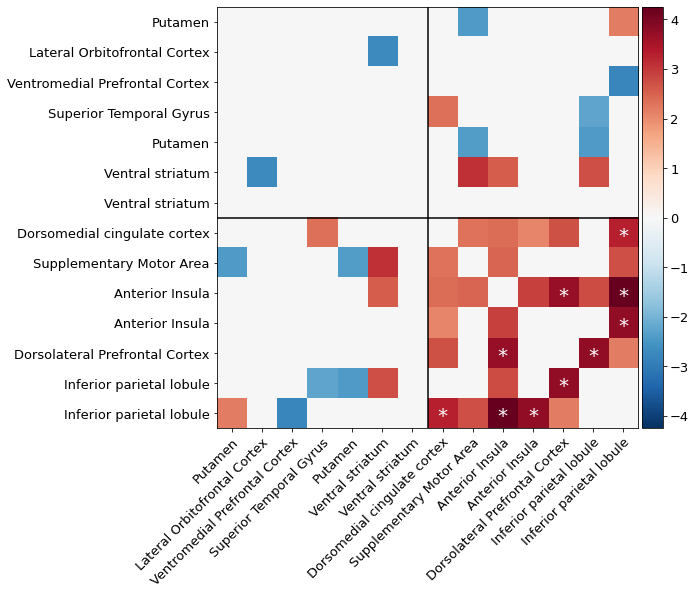

In [7]:
corr_mat = beta_mat_neqzero_pun

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(
    corr_mat[0] * (corr_mat[1] < 0.05),
    cmap='RdBu_r'
)

ax.set_xticks(np.arange(n_rois))
ax.set_yticks(np.arange(n_rois))
ax.set_xticklabels(df_custom['Regions'])
ax.set_yticklabels(df_custom['Regions'])
plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
         rotation_mode='anchor')

# Colorbar
im.set_clim([-max(np.abs(im.get_clim())), max(np.abs(im.get_clim()))])
aligned_imshow_cbar(ax, im)

# Add FDR corrected significance
for i,j in zip(*np.nonzero(corr_mat[2] < 0.05)):
    if i != j:
        ax.text(j, i+0.1, '*', ha='center', va='center', color='w', fontSize=20)
        
# Separate networks
ax.axvline(6.5, color='k')
ax.axhline(6.5, color='k')

r = 0.65
p-value = 0.00013


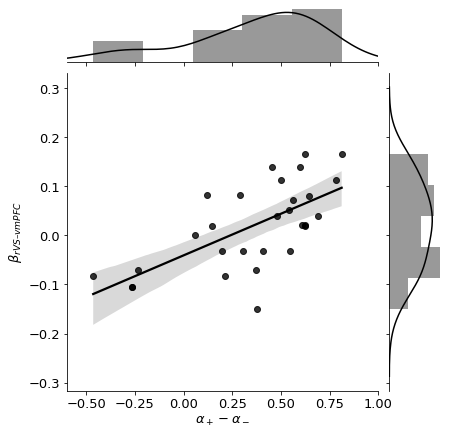

In [8]:
vec_beh = alpha_pdci_mle[ok_index, 0] - alpha_pdci_mle[ok_index, 1] 
vec_net = beta_mats_agg_sym[:, 0, beta_idx, 2, 6] 
#vec_net = beta_mats_agg_sym[:, 1, beta_idx, 2, 6] 

print('r = {:.2f}\np-value = {:.5f}'.format(*pearsonr(vec_beh, vec_net)))

ax = sns.jointplot(
    vec_beh, 
    vec_net, 
    kind='reg',
    xlim=[-0.6, 1],
    color='k'
)
plt.xlabel(r'$\alpha_+ - \alpha_-$')
plt.ylabel(r'$\beta_{rVS – vmPFC}$')
plt.show()